# Deep Learning

## Aufgabem
1. _Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)._
2. _Überlegen Sie sich eine geeignete Netzwerkarchitektur für die Klassifikationsaufgabe._
3. _Implementieren Sie Ihr Netzwerk in Keras/Tensorflow._
4. _Wahlen Sie eine geeignete Loss-Funktion und einen geeigneten Optimizer. Begründen Sie Ihre
Auswahl in Ihrem Kurzreport._
5. _Evaluieren Sie Ihr ML-System und stellen Sie die Ergebnisse in geeigneter Weise dar. Nutzen Sie
zur Evaluation eine Kreuzvalidierung (3-fold)._
6. _In dem Notebook `transfer_learning.ipynb`_

# Imports

Die Config wurde ausgelagert, da _Transfer Learning_ ähnliche Bedingungen benötigt.  


In [1]:
import tensorflow as tf
import keras
import numpy as np
import os
from pathlib import Path
import numpy as np
import sys
import random
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline


notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))
from utils.setup import setup_dataset, generateDatasetArrays
from helper.visualize import visualize_history, visualize_predictions

# load configuration
import config as Config
random.seed(Config.RANDOM_SEED)
np.random.seed(Config.RANDOM_SEED)
tf.random.set_seed(Config.RANDOM_SEED)

2024-12-17 12:43:45.136107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734435825.147035  117193 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734435825.150344  117193 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 12:43:45.162110: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Laden der Daten und Splitting in Trainings- und Testdaten (Aufgabe 1)
Dieser Schritt ist identisch bei _Merkmalsbasierte Klassifikation_, _Deep Learning_ und _Transfer Learning_ und wurde somit in `setup.py` ausgelagert.
Dort wird das Verhältnis durch `split=['train[75%:]', 'test[:25%]']` erstellt. 

In [2]:
train_dataset, test_dataset, label_lookup_table, info = setup_dataset('../dataset', labels=Config.DOG_LABEL_IDS)

def preprocess(data):
    data["original_image"] = tf.identity(data["image"])
    data["image"] = tf.image.resize(data["image"], Config.RESIZE_SIZE)
    data["label"] = label_lookup_table.lookup(data["label"])
    return data


train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(1000)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .shuffle(100)
        .prefetch(tf.data.AUTOTUNE)
)

I0000 00:00:1734435827.487128  117193 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7948 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:08:00.0, compute capability: 8.6
2024-12-17 12:43:47.587739: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-12-17 12:43:48.840186: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Image count:  500


2024-12-17 12:43:49.676492: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Dataset Size: 375
Test Dataset Size: 125


In [3]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(*Config.RESIZE_SIZE, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(Config.NUM_CLASSES, activation='softmax')
])

if Config.DEBUG:
    model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,586,885 (112.87 MB)

 Trainable params: 29,586,437 (112.86 MB)

 Non-trainable params: 448 (1.75 KB)

## Training des Models (Aufgabe 5)

2024-12-17 12:43:52.741054: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fold 1 am Laufen
Epoch 1/20


I0000 00:00:1734435834.545264  117382 service.cc:148] XLA service 0x7f96d0012040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734435834.545283  117382 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-17 12:43:54.592354: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734435834.752457  117382 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2031 - loss: 3.3813 

I0000 00:00:1734435844.007914  117382 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2300 - loss: 3.3718 - val_accuracy: 0.2320 - val_loss: 3.5959
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.3142 - loss: 2.6826 - val_accuracy: 0.2800 - val_loss: 2.6418
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4739 - loss: 1.6475 - val_accuracy: 0.2480 - val_loss: 2.8129
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5788 - loss: 1.5080 - val_accuracy: 0.3600 - val_loss: 1.9560
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.6062 - loss: 1.0908 - val_accuracy: 0.3600 - val_loss: 1.7607
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6479 - loss: 0.9605 - val_accuracy: 0.3920 - val_loss: 1.6478
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.6328 - loss: 0.9380 - val_accuracy: 0.3840 - val_loss: 1.6062
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6803 - loss: 0.9704 - val_accuracy: 0.3760 - val_loss: 1.5603
Epoch 9/2

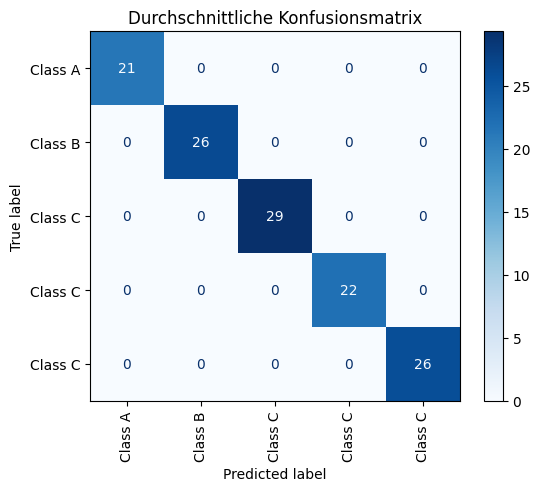

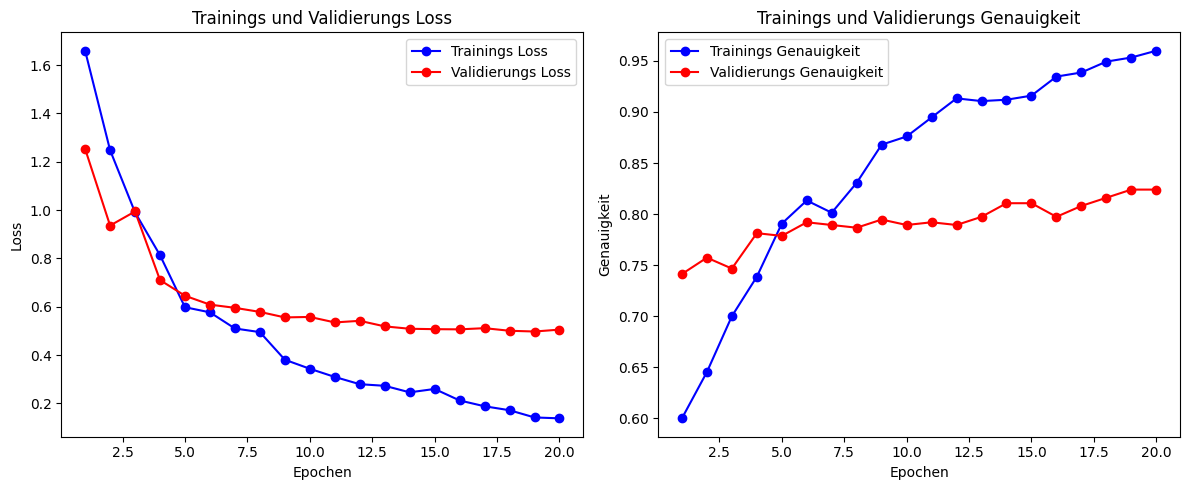

In [4]:
# Kreuzvalidierung (3-fold)
kf = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=Config.RANDOM_SEED
)

"""
It somehow is simpler using numpy arrays instead of tf.data.Dataset for fitting the model.

So we will convert the tf.data.Dataset to numpy arrays.
"""
images, labels = generateDatasetArrays(train_dataset)

history = []
fold = 1
conf_matrices = []
all_y_true = []
all_y_pred = []
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

for train_indexes, val_indexes in kf.split(images, labels):
    print(f"Fold {fold} am Laufen")
    images_train_fold, images_val_fold = images[train_indexes], images[val_indexes]
    labels_train_fold, labels_val_fold = labels[train_indexes], labels[val_indexes]
    
    fold_history = model.fit(
        images_train_fold,
        labels_train_fold,
        validation_data=(images_val_fold, labels_val_fold),
        epochs=Config.EPOCHS,
        batch_size=Config.BATCH_SIZE,
        verbose=1 if Config.DEBUG else 0
    )
    history.append(fold_history.history)

    # Evaluation
    y_pred = model.predict(images_val_fold)
    print(y_pred)
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_val_int = np.argmax(y_pred, axis=1)

    # Speichern der Konfusionsmatrix
    conf_matrices.append(confusion_matrix(y_val_int, y_pred_classes))

    # Speichern der Labels für den Report
    all_y_true.extend(y_val_int)
    all_y_pred.extend(y_pred_classes)

    fold += 1

print(history)
images_test, labels_test = generateDatasetArrays(test_dataset)
loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy: %.3f' % acc)

class_labels = ["Class A", "Class B", "Class C", "Class C", "Class C"]
print("\nKlassifizierungsbericht (Gesamtergebnis aus allen Folds):\n")
print(classification_report(all_y_true, all_y_pred, target_names=class_labels))

print("Konfusionsmatrix:")

# Mittelwert der Konfusionsmatrizen berechnen
avg_conf_matrix = np.mean(conf_matrices, axis=0)
import matplotlib.pyplot as plt 
# Visualisierung der Konfusionsmatrix
disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Durchschnittliche Konfusionsmatrix")
plt.show()

avg_history = {
    'loss': np.mean([h['loss'] for h in history], axis=0),
    'accuracy': np.mean([h['accuracy'] for h in history], axis=0),
    'val_loss': np.mean([h['val_loss'] for h in history], axis=0),
    'val_accuracy': np.mean([h['val_accuracy'] for h in history], axis=0)
}

# Visualize the history
visualize_history(avg_history)

# Save the model
model.save_weights(os.path.join(Config.MODEL_FOLDER, Config.WEIGHTS_FILENAME))
model.save(os.path.join(Config.MODEL_FOLDER, Config.MODEL_FILENAME))

# Model erstellen (Aufgabe 2 und 3)

Hier wird eine Sequentielle Netzwerkarchitektur für die Aufgabe der Klassifizierung gewählt.


## Wahl einer geeigneten Lossfunktion und eines Optimizers (Aufgabe 4)
**Loss-Funktion:** SparseCategoricalCrossentropy <br>
Diese Funktion eignet sich für Multi-Klassen-Klassifikationsprobleme und misst die Divergenz zwischen den vorhergesagten Wahrscheinlichkeiten und den tatsächlichen Klassenlabels.

**Optimizer:** Adam <br>
Der Adam-Optimizer kombiniert die Vorteile von AdaGrad und RMSProp und passt die Lernrate für jeden Parameter dynamisch an. Er ist robust und effizient, besonders bei großen Datenmengen und komplexen Modellen.

# Tests des Modells (Aufgabe 5 Teil 2)

#### Precision
Precision misst den Anteil der korrekt als positiv klassifizierten Instanzen an allen als positiv klassifizierten Instanzen. In diesem Bericht variieren die Precision-Werte zwischen 0.59 und 0.78, was bedeutet, dass zwischen 59% und 78% der als jeweilige Hunderasse vorhergesagten Instanzen tatsächlich korrekt waren.

#### Recall
Recall misst den Anteil der korrekt als positiv klassifizierten Instanzen an allen tatsächlich positiven Instanzen. Hier liegen die Recall-Werte zwischen 0.53 und 0.89, was zeigt, dass das Modell zwischen 53% und 89% der tatsächlichen positiven Instanzen korrekt erkannt hat.

#### Zusammenfassung
Zusammengefasst zeigt das CNN-Modell solide Leistungen bei der Klassifikation der fünf Hunderassen mit einer durchschnittlichen Genauigkeit von 0,71, was deutlich über zufälligem Raten (20%) liegt, womit das Trainieren des Modells als Erfolg gewertet werden kann. Dass Schipperke und Greater Mountain Dog schlechter abschneiden, liegt vor allem daran, dass es weniger Bilder von diesen gibt, das Gegenteil gilt für den Maltese Dog, der die meisten Bilder hat und deshalb am besten abschneidet. 

Deshalb wäre ein Ansatz  die Genauigkeit zu erhöhen, dass man Rassen mit gleich vielen Bildern wählt. Man könnte auch den ähnlichen Ansatz der Data Augmentation wählen, um eine gleiche Anzahl von Daten pro Rasse zu schaffen.
Eine weitere Möglichkeit ist die generelle Erhöhung des Datensatzes, zum Beispiel durch externe Quellen.
Auch könnte man das Modell auf mehr Epochen laufen lassen und dann mit der Early Stopping Funktion ein Overfitting verhindern.

---

In der letzen Sektion _Training des Models_ wurde bereits das Model mit dem Testdatensatz getestet.
Hier werden ein paar zufällige Bilder aus dem Datensatz Klassifiziert und das Ergebnis visuell dargestellt.

2024-12-17 12:45:22.598746: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


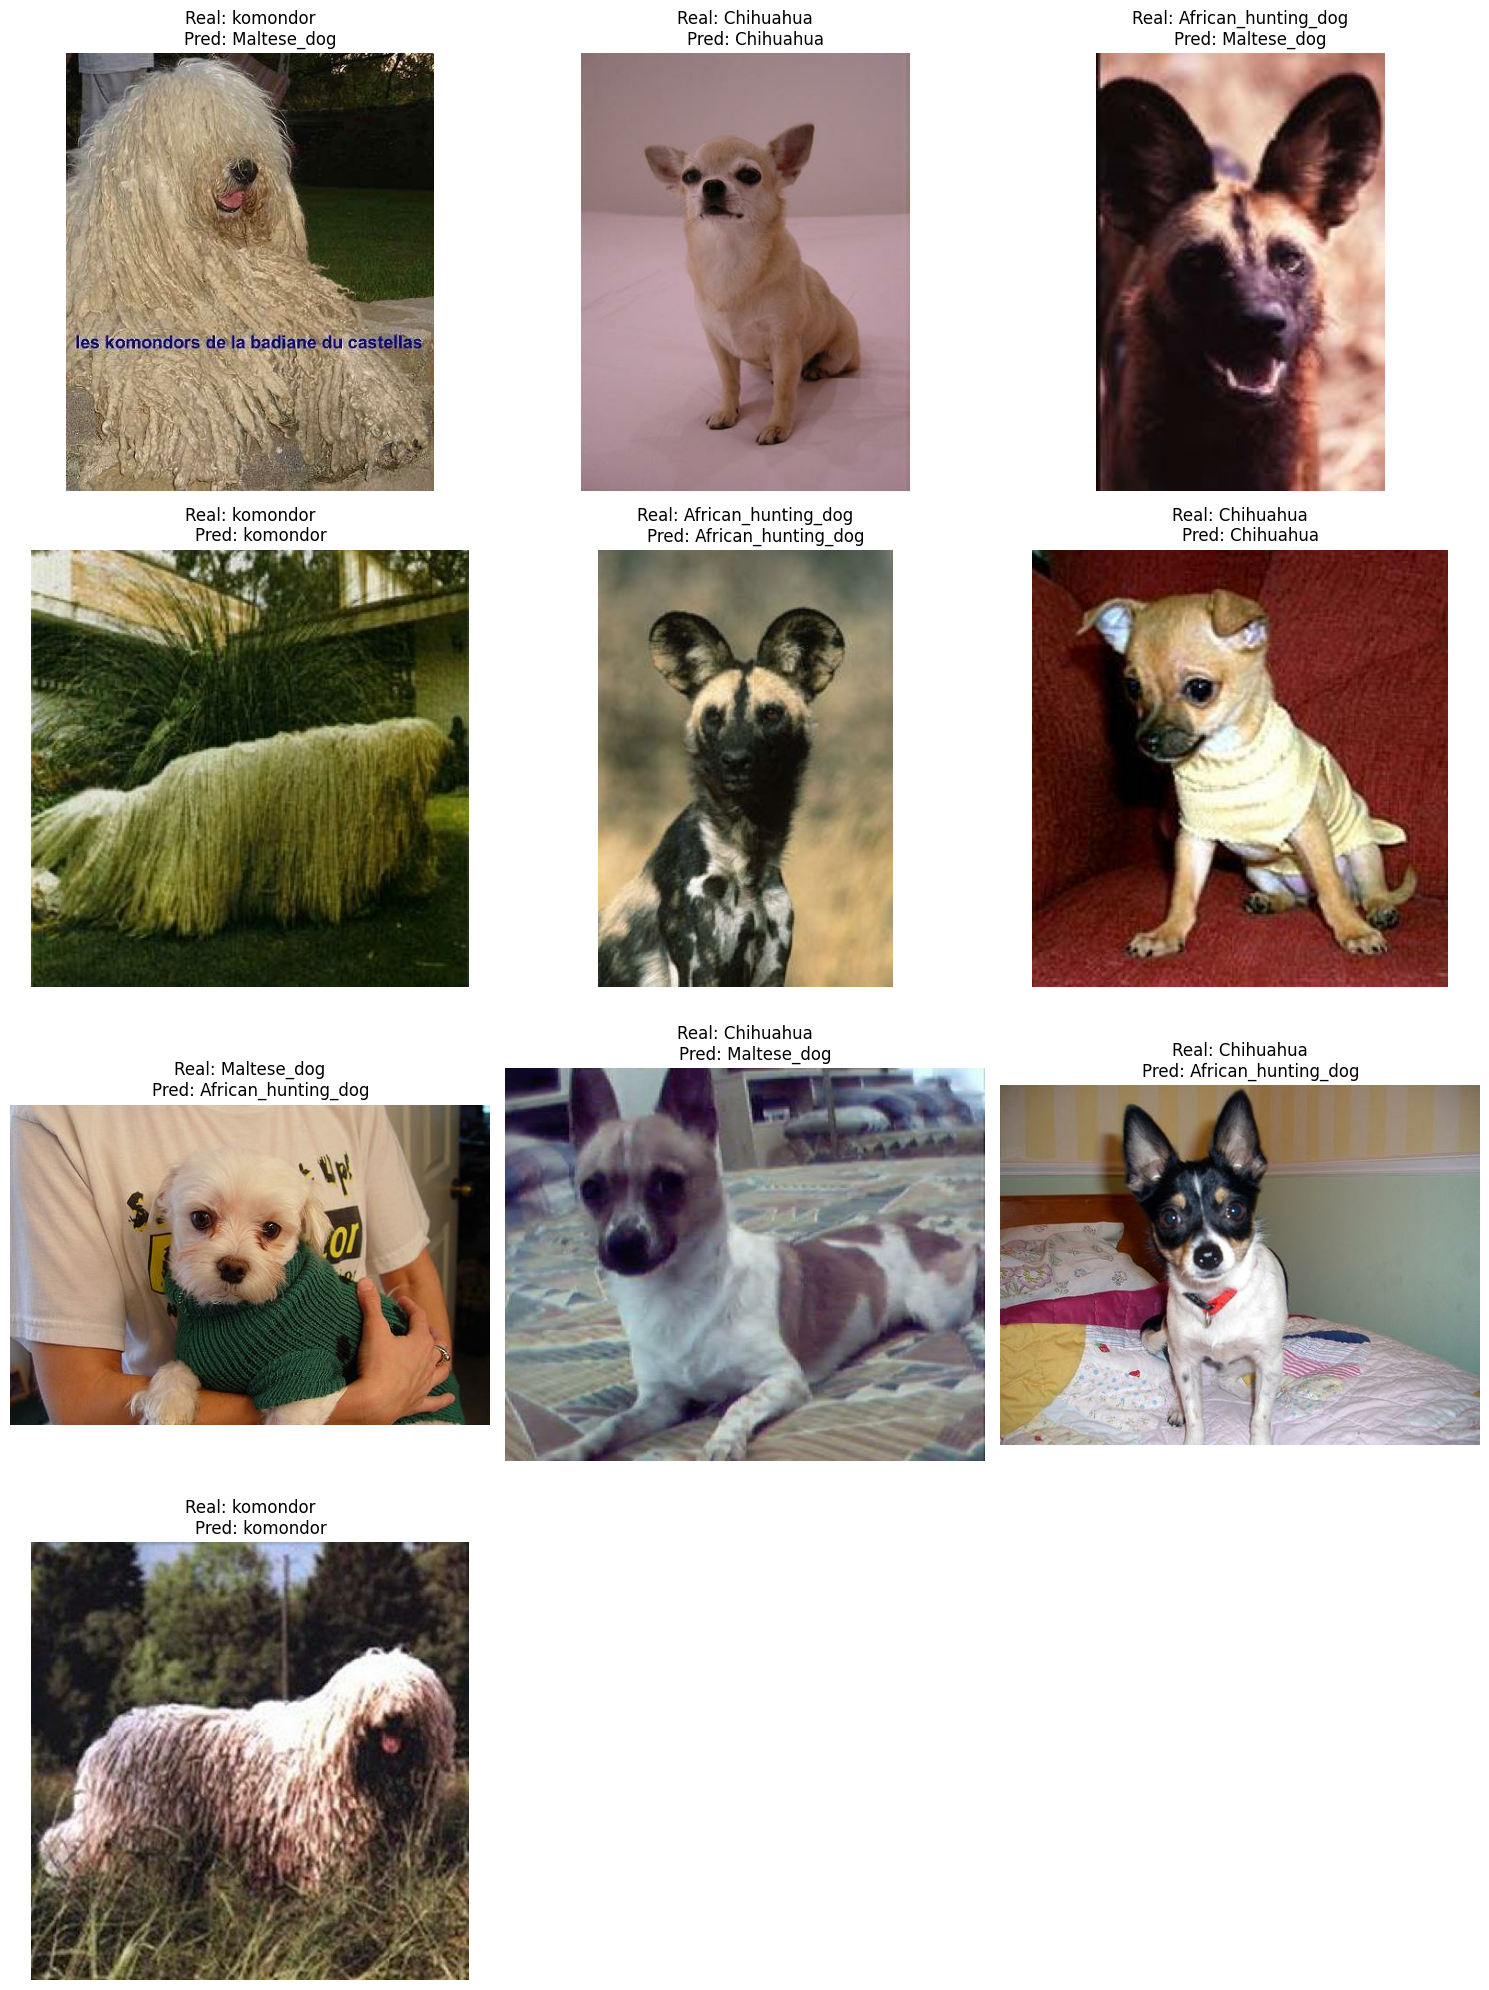

In [5]:
visualize_predictions(
    os.path.join(Config.MODEL_FOLDER, Config.MODEL_FILENAME),
    test_dataset
)